In [36]:
import pandas as pd
import numpy as np

# 머신러닝 도구
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 불균형 데이터를 위한 라이브러리
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedRandomForestClassifier

# 평가 지표
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix

# 경고 무시
from warnings import filterwarnings
filterwarnings('ignore')

In [13]:
# --- 데이터 로드
# df = pd.read_csv('./data/netflix_userdata_denoised.csv')
df = pd.read_csv('./data/netflix_feature_engineered.csv')

In [14]:
# --- 데이터 전처리

# 'Churn' 컬럼을 0(No)과 1(Yes)로 변환
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# 모델링에 불필요한 컬럼 제거
# df = df.drop(['Customer ID'], axis=1)

# 결측치 처리
# 수치형 - 각 컬럼의 중위값 / 범주형 - 각 컬럼의 최빈값
for col in df.select_dtypes(include=np.number).columns:
    if df[col].isnull().any():
        df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().any():
        mode_value = df[col].mode()[0]
        df[col].fillna(mode_value, inplace=True)

In [15]:
df

,Subscription Length (Months),Customer Satisfaction Score (1-10),Daily Watch Time (Hours),Engagement Rate (1-10),Device Used Most Often,Region,Payment History (On-Time/Delayed),Subscription Plan,Support Queries Logged,Monthly Income ($),Promotional Offers Used,Number of Profiles Created,Churn,Age_group,User_Subscription_Price,Price_Burden_Ratio,Watch_Time_per_Dollar,Satisfaction_per_Dollar,Queries_per_Month
0,12.0,10.0,4.85,4.0,Tablet,Europe,On-Time,Basic,10.0,6250.0,5.0,2.0,1,30.0,9.544634,0.001527,0.508139,1.047709,0.833333
1,12.0,8.0,1.75,9.0,Laptop,Europe,On-Time,Basic,9.0,7018.0,1.0,5.0,1,20.0,9.544634,0.001360,0.183349,0.838167,0.750000
2,3.0,4.0,2.75,9.0,Smart TV,Asia,On-Time,Premium,3.0,1055.0,1.0,5.0,1,10.0,12.836000,0.012167,0.214241,0.311624,1.000000
3,3.0,7.0,3.00,9.0,Smart TV,Europe,On-Time,Premium,5.0,6707.0,5.0,4.0,1,30.0,19.483529,0.002905,0.153976,0.359278,1.666666
4,24.0,2.0,1.37,5.0,Mobile,North America,On-Time,Standard,2.0,1506.0,3.0,5.0,1,50.0,12.473659,0.008283,0.109831,0.160338,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119774,1.0,3.0,3.52,7.0,Laptop,Asia,Delayed,Basic,5.0,4022.0,0.0,1.0,1,40.0,6.500000,0.001616,0.541538,0.461538,4.999995
119775,6.0,6.0,3.54,1.0,Laptop,Europe,On-Time,Basic,9.0,4216.0,5.0,5.0,1,40.0,9.544634,0.002264,0.370889,0.628625,1.500000
119776,24.0,2.0,0.52,10.0,Desktop,North America,Delayed,Premium,3.0,8145.0,0.0,1.0,1,50.0,16.641220,0.002043,0.031248,0.120183,0.125000
119777,12.0,1.0,3.68,1.0,Laptop,Asia,Delayed,Basic,8.0,3664.0,3.0,2.0,1,20.0,6.500000,0.001774,0.566154,0.153846,0.666667


In [16]:
# --- 데이터 분리
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [20]:
df.drop(['Device Used Most Often', 'Region', 'Payment History (On-Time/Delayed)', 'Number of Profiles Created'], axis=1, inplace=True)

In [41]:
# --- 가중치 조정
# 가중치 배열 생성 -> 기본 가중치 1
sample_weights = np.ones(len(y_train))

# 가중치 부여 조건 설정(EDA 결과 기반)
# 조건 2: 고객 중 20~50대인 경우 가중치 2 부여
condition2 = (y_train == 0) & (X_train['Age_group'].isin(['50', '60', '70']))
sample_weights[condition2] = 2

# 조건 1. 이탈 고객 중 구독 기간이 6개월 이하인 경우 가중치 3 부여
condition1 = (y_train == 0) & (X_train['Subscription Length (Months)'] > 6)
sample_weights[condition1] = 3

# 조건 3: 소수 클래스 자체에 기본적으로 추가 가중치
condition3 = (y_train == 0)
sample_weights[condition3] = 9

In [42]:
# --- 스케일링 및 인코딩
numerical_features = X.select_dtypes(include=np.number).columns.drop('Age_group').tolist() # Age_group은 전처리에서 제외
categorical_features = X.select_dtypes(include='object').columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

In [58]:
# 데이터 전처리 적용
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

# 모델 정의 및 학습
model = LGBMClassifier()
model.fit(X_train_processed, y_train, sample_weight=sample_weights)

# 평가
# best_threshold, y_pred = predict_equal_precall(model, X_test_processed, y_test)
# best_threshold, y_pred = predict_equal_recall(model, X_test_processed, y_test)
best_threshold, y_pred = predict_equal_precision(model, X_test_processed, y_test)

print(f"최적 임계값: {best_threshold:.2f}")
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 74803, number of negative: 9042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 83845, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.478951 -> initscore=-0.084247
[LightGBM] [Info] Start training from score -0.084247
최적 임계값: 0.08
              precision    recall  f1-score   support

           0       0.50      0.00      0.00      3875
           1       0.89      1.00      0.94     32059

    accuracy                           0.89     35934
   macro avg       0.70      0.50      0.47     35934
weighted avg       0.85      0.89      0.84     35934



In [57]:
# --- 정밀도와 재현율이 같아지는 임계값 찾기
def predict_equal_precall(model, X_test, y_test):
    # predict_proba -> (Class 0, Class 1)
    pred_proba = model.predict_proba(X_test)[:, 1]

    # 최적의 임계값 찾기 -> 정밀도와 재현율이 교차하는 지점의 인덱스
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)

    idx = np.argmin(np.abs(precisions - recalls))
    best_threshold = thresholds[idx]

    y_pred = (pred_proba >= best_threshold).astype(int)

    return best_threshold, y_pred

# --- 두 클래스에 대한 재현율이 같아지는 임계값 찾기
def predict_equal_recall(model, X_test, y_test):
    pred_proba = model.predict_proba(X_test)[:, 1]

    # 클래스 1을 기준으로 계산
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)

    # 각 임계값에 대한 Recall을 저장할 리스트
    tnr_scores = []
    
    for th in thresholds:
        y_pred_temp = (pred_proba >= th).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
        
        tnr = tn / (tn + fp)
        tnr_scores.append(tnr)

    diffs = np.abs(recalls[:-1] - tnr_scores)
    best_idx = np.argmin(diffs)
    
    best_threshold = thresholds[best_idx]
    
    y_pred = (pred_proba >= best_threshold).astype(int)

    return best_threshold, y_pred

# --- 두 클래스에 대한 정밀도가 같아지는 임계값 찾기
def predict_equal_precision(model, X_test, y_test):
    pred_proba = model.predict_proba(X_test)[:, 1]

    # 클래스 1을 기준으로 계산
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)

    # 각 임계값에 대한 Precision을 저장할 리스트
    pre_scores = []
    
    for th in thresholds:
        y_pred_temp = (pred_proba >= th).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
        
        pre = tn / (tn + fn) if (tn + fn) > 0 else 0
        pre_scores.append(pre)

    diffs = np.abs(precisions[:-1] - pre_scores)
    best_idx = np.argmin(diffs)
    
    best_threshold = thresholds[best_idx]
    
    y_pred = (pred_proba >= best_threshold).astype(int)

    return best_threshold, y_pred

In [39]:
# 정밀도 vs 재현율 시각화 모듈
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(10, 6))

    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

    plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best F1 Threshold: {best_threshold:.2f}')
    
    plt.title('Precision-Recall vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')

    plt.grid()
    plt.legend()

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.show()

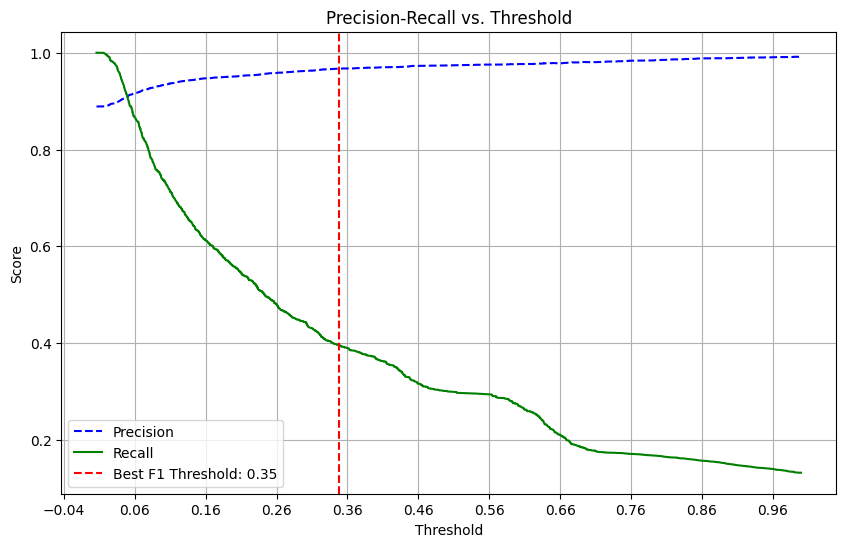

In [66]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)